In [ ]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c spai-signal-sleep-staging-classification
!unzip /content/spai-signal-sleep-staging-classification.zip -d /content/sleep-stage
!rm -rf /content/spai-signal-sleep-staging-classification

Streaming output truncated to the last 5000 lines.
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00448.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00449.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00450.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00451.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00452.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00453.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00454.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00455.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00456.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/test004_00457.csv  
  inflating: /content/sleep-stage/test_segment/test_segment/test004/t

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm
import random
import glob
import os

In [ ]:
temp = pd.read_csv('/content/sleep-stage/train/train/train001.csv')
temp.head()

,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage
0,25.325870,-21.809247,-60.302750,4.940839,31.722653,0.064595,72.015570,1.050338,W
1,20.021505,-19.437787,-60.565345,7.408788,31.722647,0.064523,72.015802,1.050338,W
2,16.314478,-21.624667,-61.142561,4.105717,31.722735,0.064659,72.017417,1.050338,W
3,9.324392,-21.761314,-61.985822,3.972967,31.722564,0.064440,72.013801,1.050338,W
4,-1.014338,-19.055301,-59.934137,9.097628,31.722790,0.065397,72.018920,1.050338,W


## Data Prep

In [ ]:
label_map = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}

def split_chunk(file_path):
    df = pd.read_csv(file_path)
    X, y = df.drop(columns='Sleep_Stage'), df['Sleep_Stage']

    start, end = 0, 480
    chunks, y_per_chunk = [], []
    for i in range(df.shape[0]//480):
        chunks.append(X[start:end].to_numpy())

        chunk_label = y.loc[start:end].map(label_map).mode()
        y_per_chunk.append(chunk_label)

        start += 480
        end += 480

    return np.stack(chunks, axis=0), np.array(y_per_chunk)

def signal_prep(files):
    X_prep, y_prep = [], []
    for i, file in enumerate(tqdm(files)):
        X_cat, y_cat = split_chunk(file)

        if i == 0:
            X_prep = X_cat
            y_prep = y_cat
        else:
            X_prep = np.concatenate([X_prep, X_cat], axis=0)
            y_prep = np.append(y_prep, y_cat)

    return X_prep, y_prep

In [ ]:
train_path = '/content/sleep-stage/train/train'
train_files = np.sort(glob.glob(os.path.join(train_path, "*.csv")))

X_prep, y_prep = signal_prep(train_files)
print(f"Dataset: {X_prep.shape}, {y_prep.shape}")

 27%|██▋       | 22/83 [00:42<01:58,  1.95s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
traceback = {}
for key, val in label_map.items():
    traceback[val] = key

pd.crosstab(pd.Series(y_prep).map(traceback),
            columns='N').sort_values('N', ascending=False)

col_0,N
row_0,
N2,33786
W,15828
N1,7753
R,7033
N3,2345


## EDA

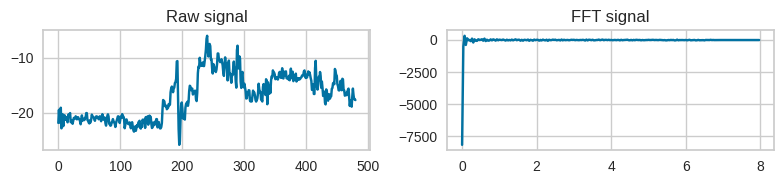

In [ ]:
index = np.where(y_prep == 0)[0][0]
sample_signal = X_prep[index]
col = 1

sampling_rate = 16
fft_signal = np.fft.fft(sample_signal[:, col])
fft_freq = np.fft.fftfreq(len(sample_signal), 1/sampling_rate)

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(sample_signal[:, col])
plt.title('Raw signal')

plt.subplot(1, 2, 2)
plt.plot(fft_freq[:len(fft_freq)//2], fft_signal[:len(fft_signal)//2])
plt.title('FFT signal')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [ ]:
from scipy.fftpack import fft

# extract stats value in each feature
def extract_time_features(chunk):
    return np.array([
        np.mean(chunk, axis=0),
        np.std(chunk, axis=0),
        np.min(chunk, axis=0),
        np.max(chunk, axis=0),
        np.median(chunk, axis=0),
    ]).flatten()

# FFT for each feature
def extract_frequency_features(chunk):
    fft_values = np.abs(fft(chunk, axis=0))[:chunk.shape[0] // 2]  # Take half spectrum
    return np.mean(fft_values, axis=0)  # Mean power spectral density

X_features = np.array([np.concatenate([extract_time_features(chunk), extract_frequency_features(chunk)])
                       for chunk in tqdm(X_prep)])
X_features.shape

100%|██████████| 66745/66745 [00:22<00:00, 2904.05it/s]


(66745, 48)

In [ ]:
columns = []
for i in range(X_features.shape[1]):
    columns.append(f"feature_{i+1}")

train_df = pd.DataFrame(X_features, columns=columns)
train_df['label'] = y_prep
train_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,label
0,2.816168,-16.982906,-61.898046,-0.012072,31.728616,0.064341,76.055451,0.962701,155.888299,4.046590,...,0.942215,2157.701622,68.348830,142.692824,34.355807,63.563525,0.142928,167.816678,2.220469,0
1,-2.661875,-18.996476,-61.551589,1.704009,31.717368,0.063908,82.436518,0.942215,123.138367,1.611204,...,0.942215,1571.834468,59.653060,130.194736,29.602599,63.552720,0.141614,171.361023,1.884429,0
2,-0.244761,-18.988383,-61.342775,5.546457,31.753257,0.063898,80.915445,0.841682,52.886585,0.679296,...,0.803199,734.839997,49.774993,126.157591,25.352579,63.712283,0.141513,164.617936,2.053027,0
3,0.004561,-18.599294,-61.364440,6.833438,31.840240,0.064328,81.789224,0.803199,76.540402,0.823913,...,0.803199,1011.223839,50.939503,127.140532,32.923520,63.912126,0.141270,167.781698,1.606399,0
4,-0.944100,-17.735414,-61.741607,4.988162,31.937764,0.064774,85.290077,0.781909,153.643422,2.986821,...,0.756861,1889.434005,57.277790,130.573146,29.982950,64.125719,0.143845,174.507276,1.965271,0


## Model Selection

In [ ]:
!pip install pycaret[models,parallel]

In [ ]:
from pycaret.classification import *
import torch

classification_setup = setup(data=train_df, target='label',
                             train_size=0.85, session_id=42, verbose=True,
                             use_gpu=torch.cuda.is_available())

best_model = compare_models(sort='F1', include=['dt', 'et', 'xgboost', 'lightgbm', 'catboost'])
best_model = create_model(best_model)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split req

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(66745, 49)"
4,Transformed data shape,"(66745, 49)"
5,Transformed train set shape,"(56733, 49)"
6,Transformed test set shape,"(10012, 49)"
7,Numeric features,48
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split req

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8154,0.9408,0.8154,0.8029,0.8048,0.7131,0.7158,3.8210
catboost,CatBoost Classifier,0.7659,0.9136,0.7659,0.7513,0.7489,0.6275,0.6346,8.1130
xgboost,Extreme Gradient Boosting,0.7581,0.9076,0.7581,0.7441,0.7388,0.6114,0.6210,2.0580
lightgbm,Light Gradient Boosting Machine,0.7345,0.8953,0.7345,0.7255,0.7088,0.5643,0.5805,4.4270
dt,Decision Tree Classifier,0.6479,0.7375,0.6479,0.6490,0.6484,0.4683,0.4683,6.4820


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8137,0.9411,0.8137,0.7991,0.8021,0.7101,0.7130
1,0.8185,0.9414,0.8185,0.8070,0.8084,0.7183,0.7208
2,0.8054,0.9369,0.8054,0.7930,0.7955,0.6977,0.7002
3,0.8209,0.9459,0.8209,0.8078,0.8093,0.7211,0.7242
4,0.8151,0.9422,0.8151,0.8023,0.8046,0.7128,0.7153
5,0.8154,0.9386,0.8154,0.8038,0.8052,0.7138,0.7163
6,0.8202,0.9436,0.8202,0.8086,0.8098,0.7207,0.7234
7,0.8075,0.9347,0.8075,0.7944,0.7956,0.6994,0.7029
8,0.8172,0.9397,0.8172,0.8053,0.8071,0.7166,0.7191


In [ ]:
tuned_model = tune_model(best_model)
evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5760,0.7836,0.5760,0.5925,0.4700,0.1916,0.2749
1,0.5710,0.7849,0.5710,0.4471,0.4640,0.1810,0.2620
2,0.5642,0.7767,0.5642,0.4721,0.4569,0.1679,0.2432
3,0.5680,0.7842,0.5680,0.4483,0.4599,0.1721,0.2553
4,0.5782,0.7854,0.5782,0.5961,0.4734,0.1958,0.2811
5,0.5755,0.7861,0.5755,0.4757,0.4705,0.1904,0.2741
6,0.5683,0.7883,0.5683,0.4451,0.4612,0.1750,0.2547
7,0.5683,0.7832,0.5683,0.4447,0.4606,0.1746,0.2550
8,0.5667,0.7882,0.5667,0.4441,0.4574,0.1700,0.2524


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# Finalize
final_model = finalize_model(best_model)
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Predictions

In [ ]:
test_path = '/content/sleep-stage/test_segment/test_segment/'
test_dir = np.sort(os.listdir(test_path))

X_test = None
check = True
for folder in tqdm(test_dir):
    files = np.sort(glob.glob(os.path.join(test_path + folder, "*.csv")))

    for file in files:
        X_cat = pd.read_csv(file)
        X_cat = X_cat.to_numpy().reshape(1, 480, X_prep.shape[2])
        if check == True:
            X_test = X_cat
            check = False
        else:
            X_test = np.concatenate([X_test, X_cat], axis=0)

print(f"Test set: {X_test.shape}")

100%|██████████| 10/10 [04:30<00:00, 27.00s/it]

Test set: (7832, 480, 8)


In [ ]:
test_features = np.array([np.concatenate([extract_time_features(chunk), extract_frequency_features(chunk)])
                       for chunk in tqdm(X_test)])
test_df = pd.DataFrame(test_features, columns=columns)
print(test_df.shape)
test_df.head()

100%|██████████| 7832/7832 [00:02<00:00, 2839.94it/s]

(7832, 48)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48
0,2.436631,-29.720045,-34.525987,45.653916,30.778961,0.772567,52.779410,0.962367,96.985414,1.788864,...,52.932178,0.911322,1183.410046,75.656710,75.716524,99.183249,61.730128,1.585002,107.156074,2.472269
1,-0.224025,-30.411827,-34.542691,45.414474,30.737413,0.781230,52.254178,1.094588,52.860653,0.398192,...,52.219784,1.111726,388.935126,65.925789,73.230052,93.745688,61.577691,1.604597,105.821962,2.484367
2,0.453667,-30.577309,-34.522156,45.370780,30.724233,0.790380,52.923120,1.116953,47.620881,0.261682,...,52.887733,1.128108,427.922414,65.011899,72.392172,94.100934,61.584323,1.620897,106.245802,2.553752
3,-0.237769,-30.613100,-34.547892,45.316746,30.709755,0.797104,52.781728,1.112376,49.324602,0.209487,...,52.831257,1.118196,391.487854,64.807252,71.721999,94.804393,61.545446,1.635034,106.215910,2.532248
4,0.406600,-31.479116,-35.551089,43.615401,30.667571,0.803553,52.413342,1.103791,62.359194,0.771483,...,52.383423,1.112122,847.847128,76.409694,74.963108,95.035986,61.511811,1.644816,106.093600,2.433886


In [ ]:
y_pred = predict_model(final_model, test_df)['prediction_label'].map(traceback)
y_pred.value_counts()

prediction_label
N2    4618
W     3107
N1      98
R        9
Name: count, dtype: int64

In [ ]:
submission = pd.read_csv('/kaggle/input/spai-signal-sleep-staging-classification/sample_submission.csv')
submission.loc[3:, 'labels'] = y_pred[3:]
submission

,id,labels
0,test001_00000,W
1,test001_00001,W
2,test001_00002,W
3,test001_00003,N2
4,test001_00004,W
...,...,...
7827,test010_00754,W
7828,test010_00755,W
7829,test010_00756,W
7830,test010_00757,W


In [ ]:
submission.to_csv('extra_tree_1.csv', index=False)